# ControlNet

ControlNet is an adapter that enables controllable generation such as generating an image of a cat in a specific pose or following the lines in a sketch of a specific cat. It works by adding a smaller network of "zero convolution" layers and progressively training these to avoid disrupting with the original model. The original model parameters are frozen to avoid retraining it.

A ControlNet is conditioned on extra visual information or "structural controls" that can be combined with text prompts to generate images that are guided by the visual input. Examples of structural controls include:

- Canny edge detection
- Depth maps
- Human pose estimation
- And more...

These controls allow for precise guidance in the image generation process, enabling more accurate and controllable results.

paper:https://arxiv.org/abs/2302.05543
huggingface: https://huggingface.co/docs/diffusers/en/using-diffusers/controlnet
controlnet: https://huggingface.co/lllyasviel/ControlNet

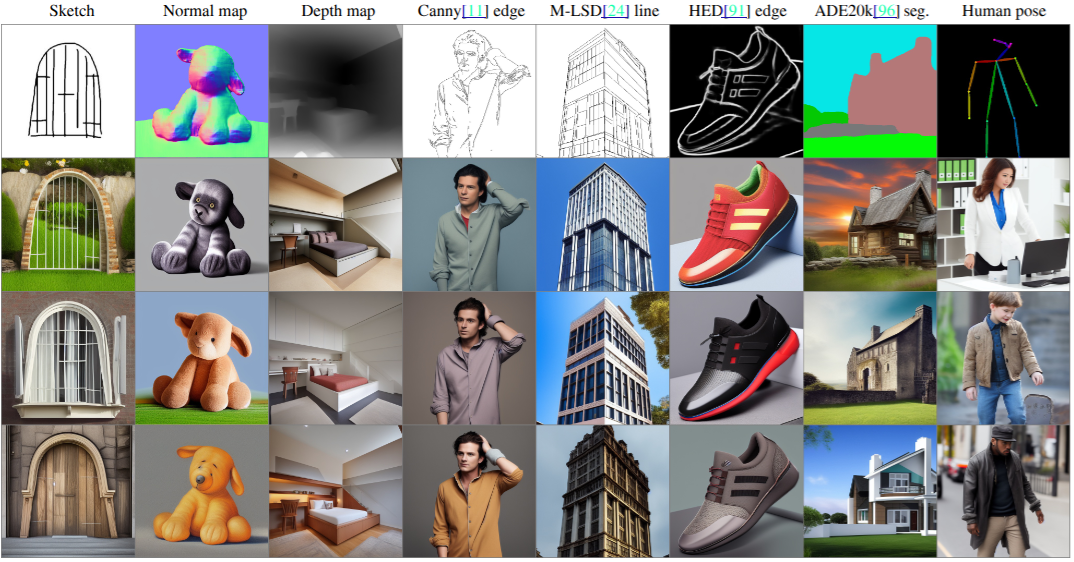

# Using Controlnet as Pipeline

In [1]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
controlnet_id = 'lllyasviel/control_v11p_sd15_canny'

controlnet = ControlNetModel.from_pretrained(controlnet_id, torch_dtype=torch.float16)
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet,safety_checker=None, torch_dtype=torch.float16
).to(device)

pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)

c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


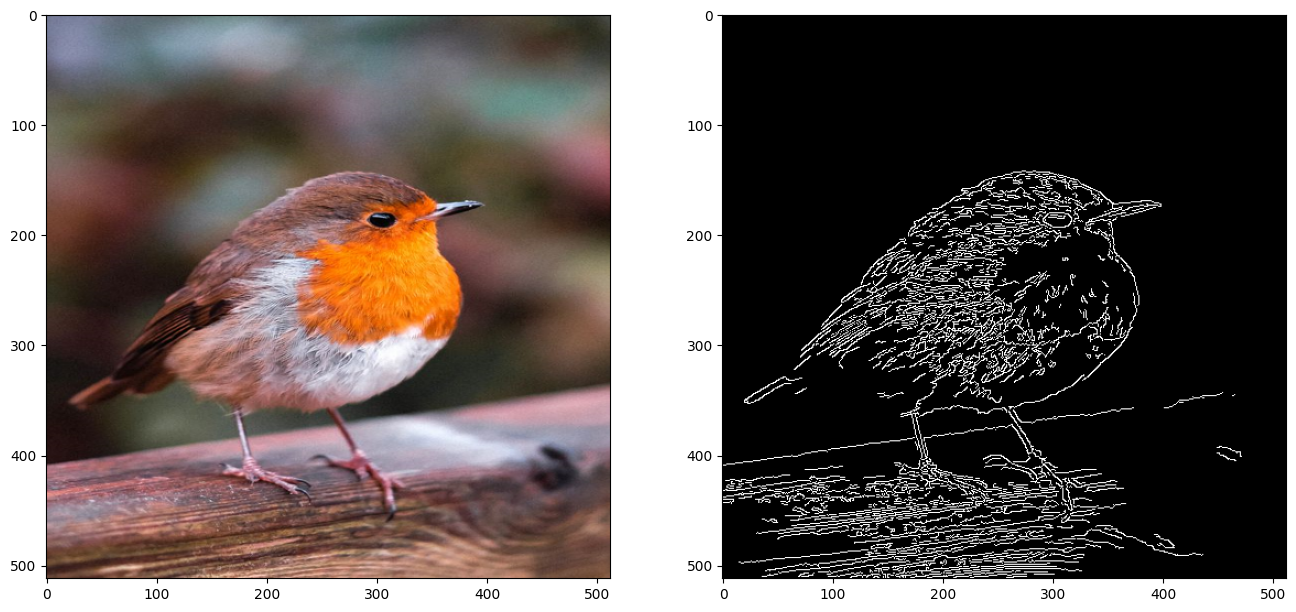

In [2]:
ref_image = load_image(
    "https://huggingface.co/lllyasviel/control_v11p_sd15_canny/resolve/main/images/input.png"
).resize((512,512))

image = np.array(ref_image)
low_threshold = 100
high_threshold = 200
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = Image.fromarray(image)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(ref_image)
plt.subplot(1,2,2)
plt.imshow(control_image)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

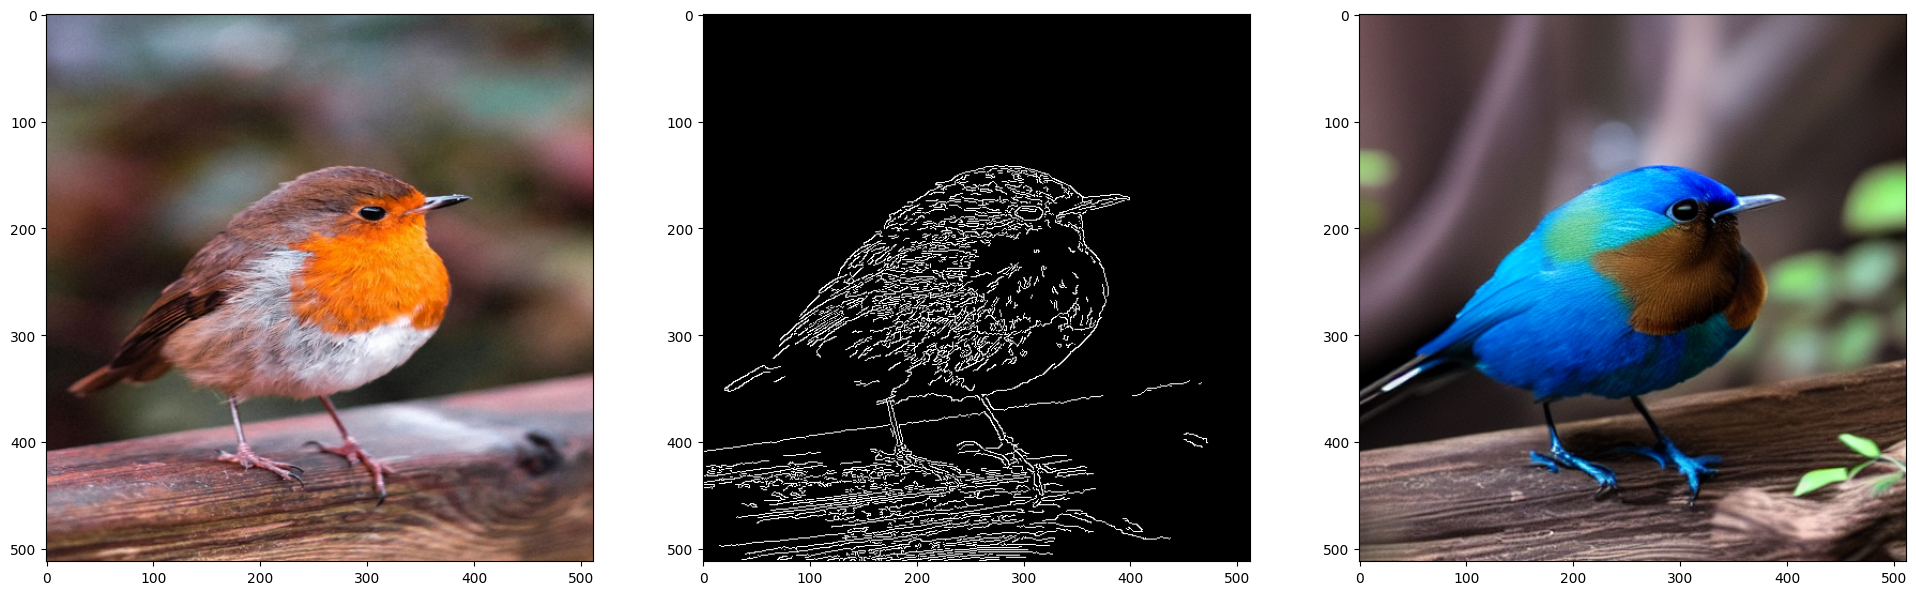

In [3]:
gen_image = pipeline("a blue paradise bird in the jungle",
                  num_inference_steps=20, 
                  image=control_image,
                  generator=torch.manual_seed(33) 
                  ).images[0]

plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(ref_image)
plt.subplot(1,3,2)
plt.imshow(control_image)
plt.subplot(1,3,3)
plt.imshow(gen_image)
plt.show()

# Using different prompts

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

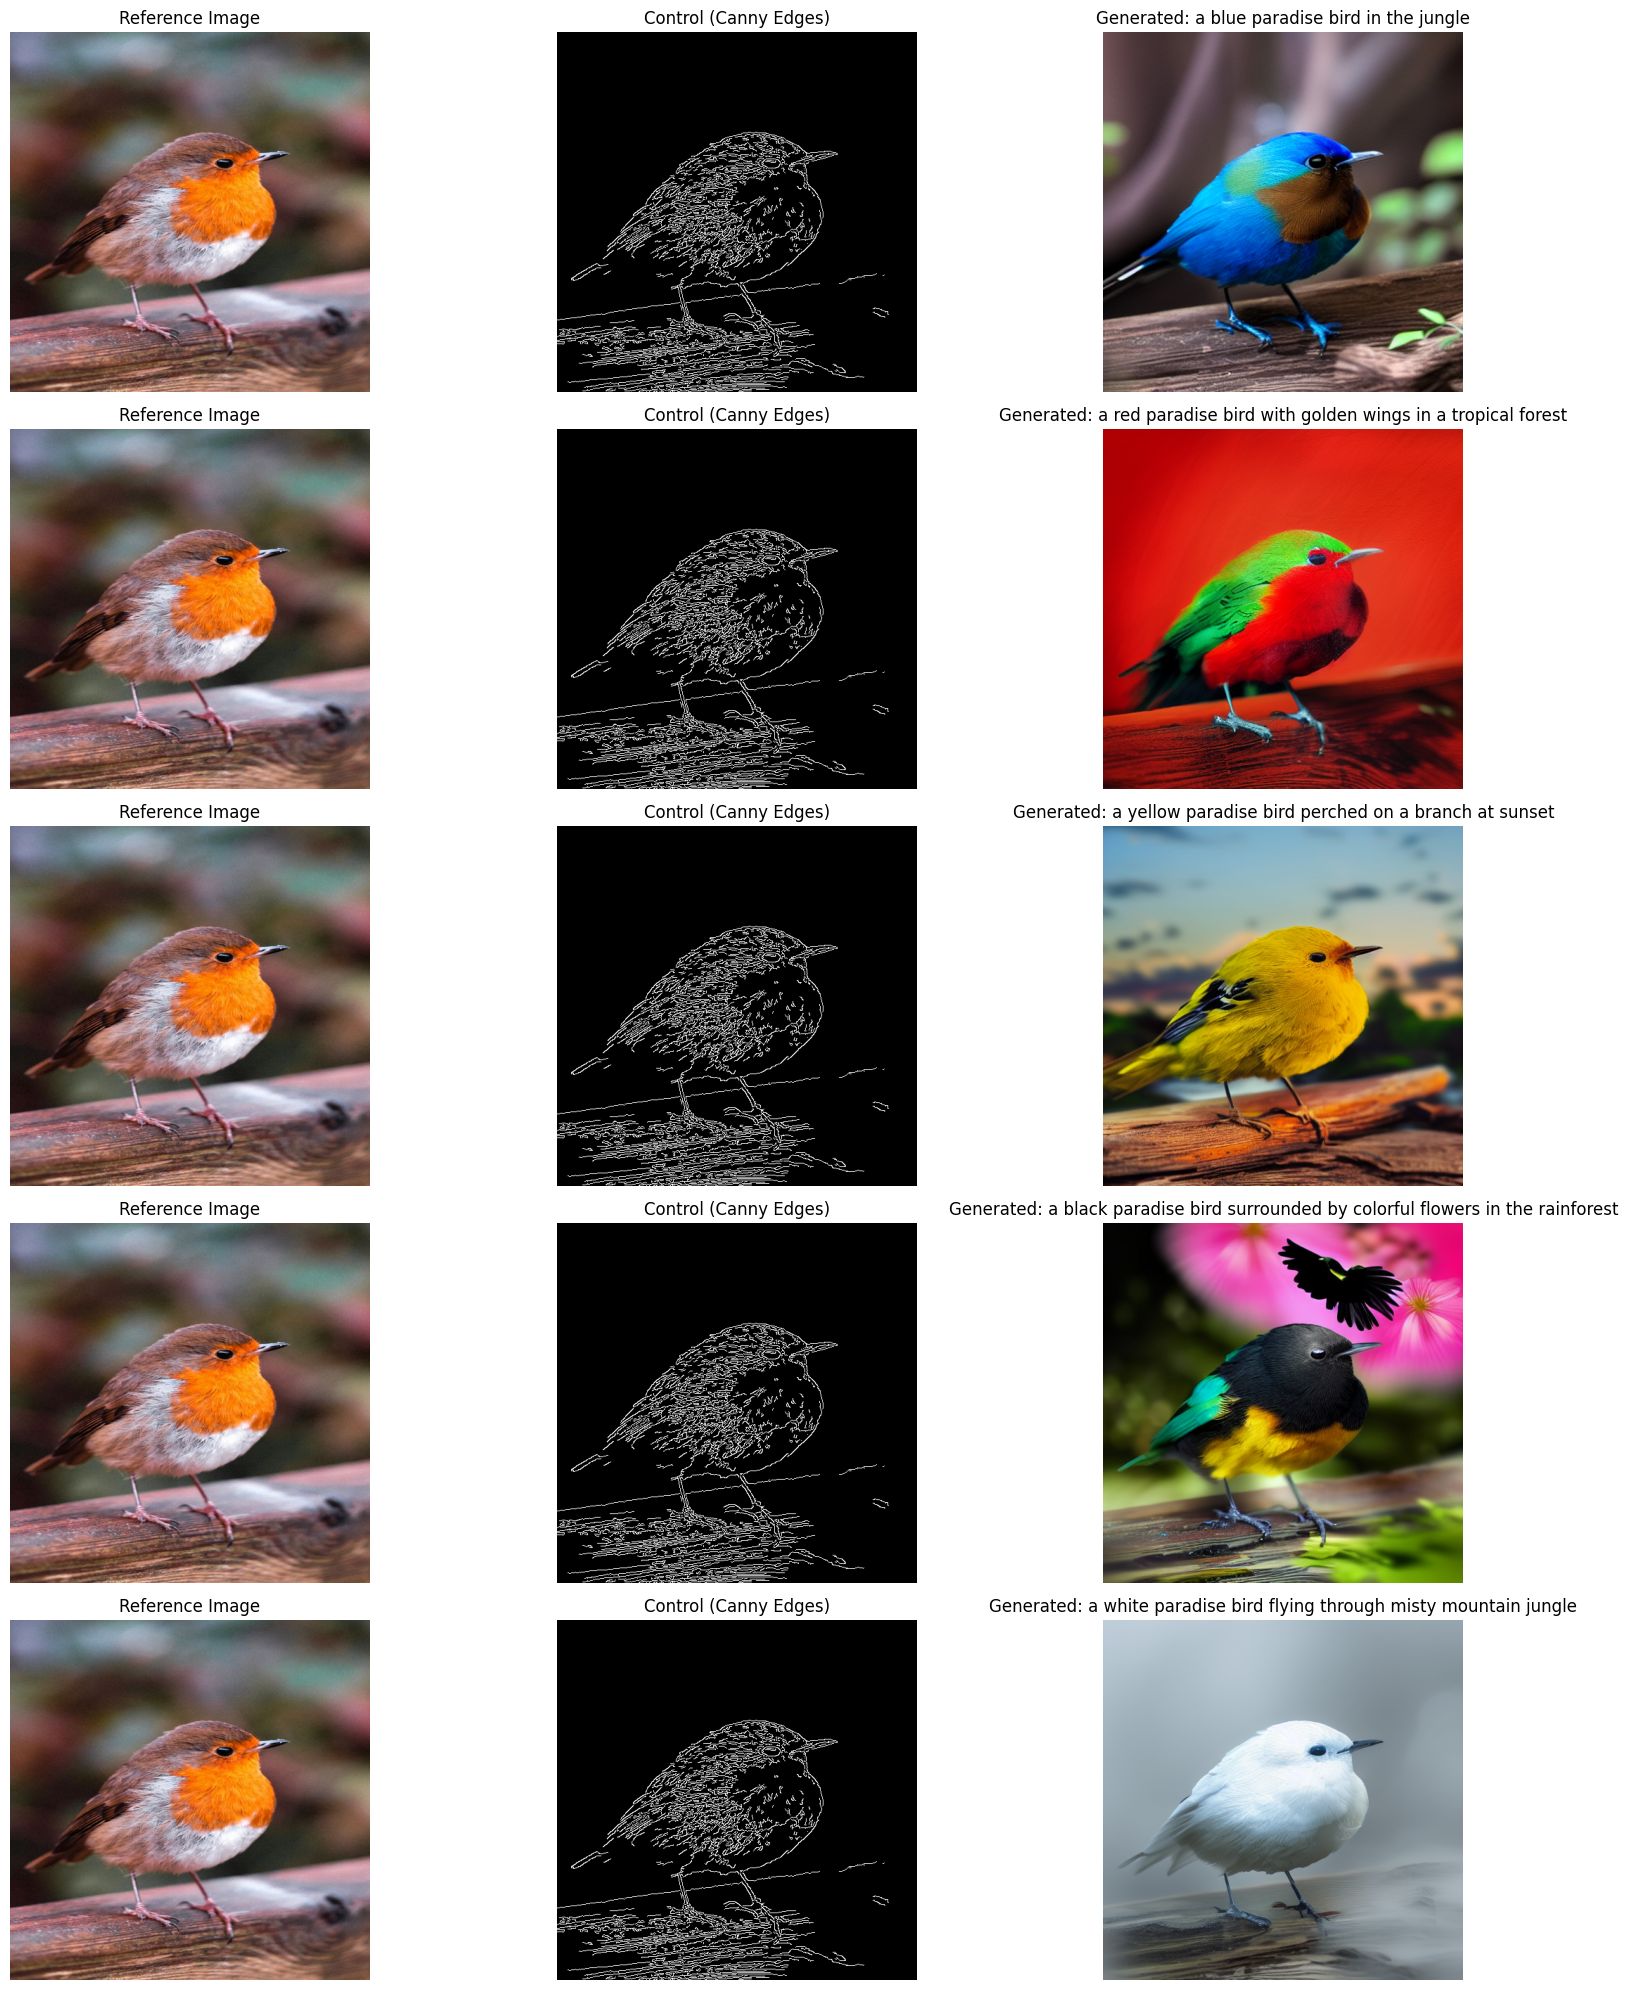

In [ ]:
prompts = [
    "a blue paradise bird in the jungle",
    "a red paradise bird with golden wings in a tropical forest",
    "a yellow paradise bird perched on a branch at sunset",
    "a black paradise bird surrounded by colorful flowers in the rainforest",
    "a white paradise bird flying through misty mountain jungle"
]

fig, axes = plt.subplots(5, 3, figsize=(18, 20))

for idx, prompt in enumerate(prompts):
    gen_image = pipeline(prompt,
                      num_inference_steps=20, 
                      image=control_image,
                      generator=torch.manual_seed(33) 
                      ).images[0]
    
    axes[idx, 0].imshow(ref_image)
    axes[idx, 0].set_title("Reference Image")
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(control_image)
    axes[idx, 1].set_title("Control (Canny Edges)")
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(gen_image)
    axes[idx, 2].set_title(f"Generated: {prompt}")
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

# How to control the Controlnet Strength

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

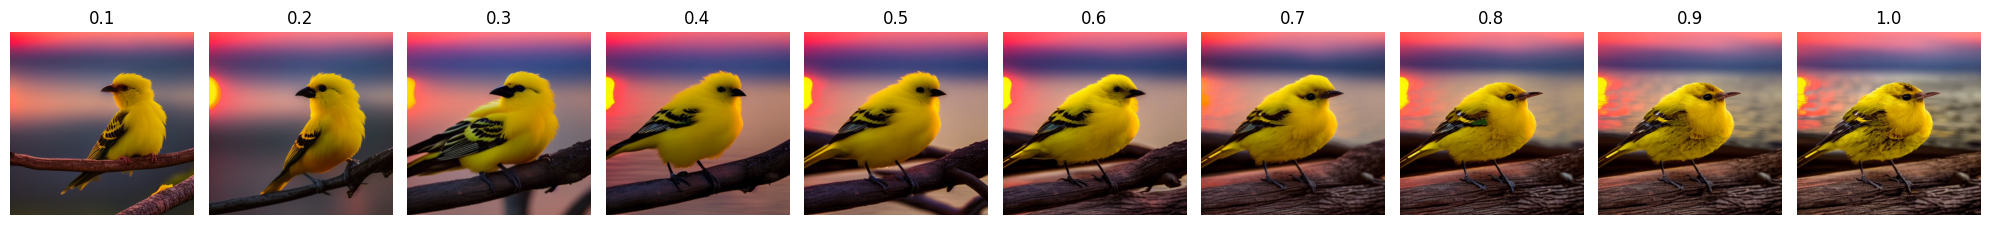

In [9]:
prompt = "a yellow paradise bird perched on a branch at sunset"
    

fig, axes = plt.subplots(1, 10, figsize=(20, 20))

for idx, controlnet_scale in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    gen_image = pipeline(prompt,
                      num_inference_steps=20, 
                      image=control_image,
                      controlnet_conditioning_scale=controlnet_scale,
                      generator=torch.manual_seed(33) 
                      ).images[0]
    
    axes[idx].imshow(gen_image)
    axes[idx].set_title(f"{controlnet_scale}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()